<a href="https://colab.research.google.com/github/rhilderbrand/MSDS-422-MachineLearning/blob/main/Hilderbrand_Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 9: Autoencoder



1.   Import and preprocess data
2.   Set parameters and define autoencoder backpropagation function
3.   Run a process to train autoencoder
4.   Visualise what the autoencoder has learned





In [ ]:
# import necessary packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics

In [ ]:
#S2 Mount Google Drive to Colab Enviorment
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#S3 Establish working directory
import os # Operation System
os.getcwd()
%cd /content/gdrive/My Drive/Colab Notebooks/Week 9/
!pwd
!ls
print('Working Directory')
print(os.getcwd())

work_dir = " /content/gdrive/My Drive/Colab Notebooks/Week 9/"

/content/gdrive/My Drive/Colab Notebooks/Week 9
/content/gdrive/My Drive/Colab Notebooks/Week 9
Hilderbrand_Assignment_9  test.csv  train.csv  Untitled0.ipynb
Working Directory
/content/gdrive/My Drive/Colab Notebooks/Week 9


In [ ]:
train = pd.read_csv('train.csv')
train = train.drop('label', axis=1)
train = train.values

test = pd.read_csv('test.csv')
test= test.values

In [ ]:
X_train = train.copy()
X_test = test.copy()

In [ ]:
# normalize all values between 0 and 1
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# input dimensions when the image size is flattened
input_dim = np.prod(X_train.shape[1:])

# flatten the 28x28 pixel image into vectors of size 784
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

print(X_train.shape)
print(X_test.shape)

(42000, 784)
(28000, 784)


In [ ]:
# size of our encoded representations
# 32 floats - compression factor 24.5, assuming input is 784 floats
encoded_dim = 32 

# sizes and number of hidden layers
hidden_layer_weights = [392, 98]
hidden_layers = len(hidden_layer_weights)

In [ ]:
# Create encoding layers.
def get_encoder(input, layers, encoded_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(encoded_dim
                              , activation='relu')(x)

# Create decoding layers.
def get_decoder(input, layers, input_dim, units):
    x = None
    for i in range(layers):
        x = keras.layers.Dense(units[i]
                               , activation='relu')(input if x is None else x)
    return keras.layers.Dense(input_dim
                              , activation='sigmoid')(x)

# Create a new stack of layers from existing layers with new input layer.
def add_new_input(input, layers):
    new_layer_stack = input
    for layer in layers:
        new_layer_stack = layer(new_layer_stack)
    return new_layer_stack


In [ ]:
# Input to encoder.
input = keras.layers.Input(shape=(input_dim,))
# Create encoder half.
encoded_layer = get_encoder(input, hidden_layers, encoded_dim, hidden_layer_weights)
# Create decoder half.
decoded_layer = get_decoder(encoded_layer, hidden_layers, input_dim, list(reversed(hidden_layer_weights)))

# Assemble full autoencoder model.
full_model = keras.models.Model(input, decoded_layer)

# Assemble encoder model.
encoder = keras.models.Model(input, encoded_layer)

# Assemble decoder model (with new input!).
decoder_input = keras.layers.Input(shape=(encoded_dim,))
decoder = keras.models.Model(decoder_input, add_new_input(decoder_input, full_model.layers[-(hidden_layers + 1):]))

In [ ]:
full_model.compile(optimizer=keras.optimizers.Adam()
                   , loss=keras.losses.binary_crossentropy
                   , metrics=[keras.metrics.binary_crossentropy])

full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 392)               307720    
_________________________________________________________________
dense_1 (Dense)              (None, 98)                38514     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                3168      
_________________________________________________________________
dense_3 (Dense)              (None, 98)                3234      
_________________________________________________________________
dense_4 (Dense)              (None, 392)               38808     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               308112

##Train and Test Autoencoder

In [ ]:
# Use early stopping to stop the training when loss does not decrease anymore.
callbacks = [keras.callbacks.EarlyStopping(patience=2)]

history = full_model.fit(X_train
               , X_train
               , batch_size=128
               , epochs=100
               , shuffle=True
               , validation_split=.1
               , callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - 6s 17ms/step - loss: 0.2867 - binary_crossentropy: 0.2867 - val_loss: 0.1352 - val_binary_crossentropy: 0.1352
Epoch 2/100
296/296 [==============================] - 5s 17ms/step - loss: 0.1296 - binary_crossentropy: 0.1296 - val_loss: 0.1138 - val_binary_crossentropy: 0.1138
Epoch 3/100
296/296 [==============================] - 5s 17ms/step - loss: 0.1108 - binary_crossentropy: 0.1108 - val_loss: 0.1049 - val_binary_crossentropy: 0.1049
Epoch 4/100
296/296 [==============================] - 5s 16ms/step - loss: 0.1029 - binary_crossentropy: 0.1029 - val_loss: 0.0998 - val_binary_crossentropy: 0.0998
Epoch 5/100
296/296 [==============================] - 5s 16ms/step - loss: 0.0984 - binary_crossentropy: 0.0984 - val_loss: 0.0964 - val_binary_crossentropy: 0.0964
Epoch 6/100
296/296 [==============================] - 5s 17ms/step - loss: 0.0946 - binary_crossentropy: 0.0946 - val_loss: 0.0935 - val_binary_crossentropy: 0.0935
Epoc

In [ ]:
print('test loss {}, test binary crossentropy {}'.format(*full_model.evaluate(X_test, X_test, batch_size=128)))

219/219 [==============================] - 1s 6ms/step - loss: 0.0826 - binary_crossentropy: 0.0826
test loss 0.08261895924806595, test binary crossentropy 0.08261895924806595


##Visualize Autoencoder

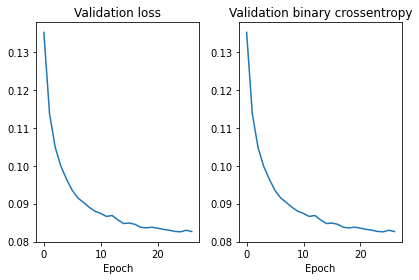

In [ ]:
fig, axes = plt.subplots(1, 2)

val_loss_ax = axes[0]
val_loss_ax.plot(history.history['val_loss'])
val_loss_ax.title.set_text('Validation loss')
val_loss_ax.set_xlabel('Epoch')

val_bincross_ax = axes[1]
val_bincross_ax.plot(history.history['val_binary_crossentropy'])
val_bincross_ax.title.set_text('Validation binary crossentropy')
val_bincross_ax.set_xlabel('Epoch')

plt.tight_layout()
plt.show()

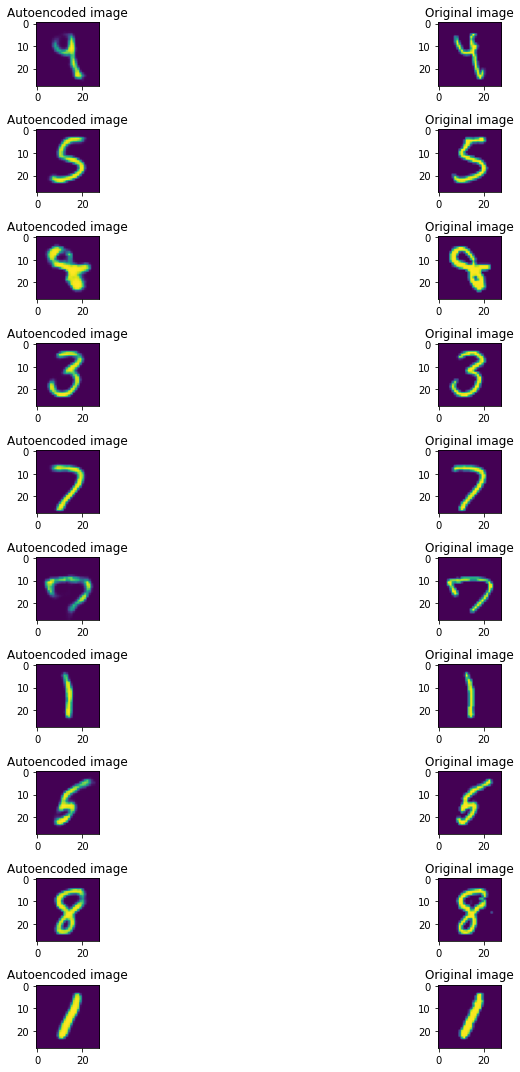

In [ ]:
# Visualize X examples.
n = 10
visualization_start_index = np.random.randint(0, len(X_test))

fig, axes = plt.subplots(1 * n, 2)

for i in range(n):
    test_index = visualization_start_index + i
    x_encoded = encoder.predict(X_test[test_index].reshape(1, -1))
    x_predicted = decoder.predict(x_encoded)    

    #Autoencoder results
    ax_predicted = axes[i][0]
    ax_predicted.imshow(x_predicted.reshape((28, 28)))
    ax_predicted.title.set_text('Autoencoded image')
    
    #Actual image.
    ax_original = axes[i][1]
    ax_original.imshow(X_test[test_index].reshape((28, 28)))
    ax_original.title.set_text('Original image')

fig.set_size_inches(15, 15)
plt.tight_layout()
plt.show()

In [ ]:
ae_test = full_model.predict(X_test)

In [ ]:
ae_train = full_model.predict(X_train)

In [ ]:
ae_train = pd.DataFrame(ae_train)
ae_test = pd.DataFrame(ae_test)

ae_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1.171305e-09,6.376689e-09,3.055131e-09,2.216853e-09,1.477972e-08,3.464909e-09,8.418755e-09,1.724933e-09,2.557263e-09,7.357885e-09,1.679338e-09,1.521790e-08,3.563012e-09,3.918790e-09,3.909943e-09,8.460896e-06,9.081099e-09,4.235518e-09,8.707808e-09,1.958946e-09,1.686140e-08,1.468051e-08,1.714571e-09,8.223672e-09,3.944963e-09,6.630947e-09,5.955984e-09,6.574851e-10,1.068389e-08,1.567116e-09,3.203081e-09,3.111346e-08,2.295461e-09,1.198181e-08,2.190725e-09,7.696569e-09,2.620058e-10,2.815233e-09,1.514478e-09,4.120739e-08,...,3.691568e-19,1.234244e-19,6.650737e-19,1.074550e-17,2.963120e-15,6.500436e-13,3.570583e-13,7.488302e-11,1.650882e-09,4.871070e-10,1.037814e-08,1.057044e-09,1.650033e-08,1.451836e-09,1.684401e-08,1.428695e-09,4.349841e-10,1.923599e-11,6.911351e-14,4.914436e-18,9.814657e-18,2.564421e-18,1.504952e-21,6.177836e-24,4.920278e-22,1.766905e-22,7.467992e-26,7.240998e-23,4.618803e-24,1.017937e-20,1.101304e-18,1.125630e-17,3.079393e-16,3.352972e-14,1.048405e-11,1.206490e-11,3.179307e-09,1.923898e-09,2.149139e-09,7.785170e-09
1,8.142227e-10,2.493340e-09,7.826406e-10,2.021858e-09,1.302900e-08,1.966028e-09,5.002620e-09,4.172802e-10,1.889488e-09,2.389549e-09,1.592375e-08,2.307327e-08,1.056948e-15,2.419247e-17,5.478420e-16,3.010450e-10,1.279158e-08,3.786426e-08,7.235582e-09,7.941626e-09,2.917713e-09,2.246354e-09,6.882822e-09,1.098859e-08,1.630156e-08,1.606335e-08,3.427979e-09,1.821354e-09,4.039594e-09,1.400505e-09,2.227810e-09,2.075693e-08,5.463235e-09,6.448727e-10,3.773250e-14,3.973864e-13,7.715355e-12,5.179106e-11,4.141748e-11,1.729887e-11,...,2.493115e-10,4.455993e-10,2.287946e-10,2.682174e-11,1.802809e-11,4.252737e-12,4.263793e-11,4.286873e-10,2.470353e-09,1.041611e-09,1.773082e-08,2.020995e-08,4.746415e-09,9.875769e-09,1.037088e-08,4.138128e-09,3.813415e-09,3.136399e-09,5.424379e-10,1.579623e-10,2.227448e-10,4.221901e-10,8.242535e-12,1.685299e-13,2.790055e-13,3.396210e-15,2.401473e-17,6.014246e-14,2.828831e-15,5.863180e-15,5.542152e-16,1.827576e-13,1.967503e-12,8.669038e-11,2.319457e-12,1.170491e-10,8.030613e-09,8.804271e-09,6.861273e-09,7.495927e-09
2,4.725005e-06,5.122346e-06,3.331083e-06,9.441538e-06,1.140870e-06,6.637918e-06,3.293735e-06,3.423737e-06,3.296302e-06,1.578374e-05,5.712210e-06,9.426109e-06,1.880767e-05,1.145740e-06,7.226414e-08,1.172946e-05,3.353267e-06,1.307661e-06,1.455591e-06,3.551365e-06,4.243554e-06,8.806115e-06,1.031609e-05,3.818493e-06,2.492476e-06,1.046575e-05,5.202430e-06,1.705973e-06,4.333089e-06,2.585889e-06,4.136769e-06,1.632199e-06,2.790541e-06,6.818383e-06,4.771349e-07,2.504636e-07,3.295470e-11,2.524484e-12,5.663812e-14,3.722316e-12,...,5.086319e-06,1.223672e-06,1.491226e-05,4.529160e-05,1.215982e-05,2.847016e-04,1.834552e-05,4.299215e-05,1.183071e-06,3.212501e-05,1.592691e-06,2.103444e-06,1.220242e-06,4.803296e-06,2.621187e-05,1.569902e-05,2.181403e-06,7.928527e-07,1.722973e-07,3.988748e-09,1.553827e-09,2.111012e-08,2.215276e-07,3.212842e-08,2.555507e-09,1.625467e-09,6.343689e-10,4.068863e-09,8.196769e-09,5.981468e-07,1.314655e-05,2.835263e-07,3.715905e-07,4.663704e-08,1.215661e-07,5.666614e-07,1.279712e-05,1.838688e-06,4.358919e-06,1.394105e-06
3,6.902397e-09,6.739598e-09,1.250413e-08,4.508429e-08,2.064211e-09,2.170525e-08,3.523748e-08,1.028189e-08,6.186490e-09,1.742073e-07,1.553202e-08,1.151063e-08,4.131111e-08,5.284067e-07,2.699346e-08,6.739425e-07,5.372948e-09,9.731657e-09,2.087373e-08,8.824142e-09,1.728576e-08,5.793928e-09,1.839720e-08,3.509849e-08,1.751570e-08,1.413619e-08,5.663243e-09,1.315277e-08,1.621486e-08,4.606485e-09,6.958352e-09,3.952791e-08,1.600618e-08,4.301249e-07,8.217926e-07,1.786833e-07,3.473194e-09,3.726529e-08,2.019215e-08,3.263970e-06,...,2.004296e-03,5.170763e-03,9.737104e-03,5.016279e-02,4.664361e

In [ ]:
train = pd.read_csv('train.csv')
y_train = train['label']

ae_train.shape, y_train.shape, ae_test.shape

((42000, 784), (42000,), (28000, 784))

In [ ]:
#Split train data to run through Random Classifier
from sklearn.model_selection import train_test_split
X_train_RC, X_test_RC, y_train_RC, y_test_RC = train_test_split(ae_train.values, y_train, test_size = 0.2, random_state= 42)

In [ ]:
RANDOM_SEED = 1

In [ ]:
%%time

import time

# create an empty list to store time results
rf_time = []

#fit a Random Forest Classifier onto the training set
from sklearn.ensemble import RandomForestClassifier

start_time = time.clock()
rf_clf = RandomForestClassifier(max_features = 'sqrt', n_estimators=10, bootstrap=True, random_state=RANDOM_SEED)
rf_clf.fit(X_train_RC,y_train_RC)
end_time = time.clock()

runtime = end_time - start_time

#append the results to the list
rf_time.append(runtime)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


CPU times: user 10.8 s, sys: 25.5 ms, total: 10.9 s
Wall time: 11 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


In [ ]:
y_pred_RC = rf_clf.predict(X_test_RC)

In [ ]:
from sklearn.metrics import classification_report

print("Random Forest Classification Report: \n{}".format(classification_report(y_test_RC, y_pred_RC)))

Random Forest Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       816
           1       0.98      0.99      0.98       909
           2       0.93      0.96      0.94       846
           3       0.92      0.93      0.92       937
           4       0.94      0.94      0.94       839
           5       0.94      0.92      0.93       702
           6       0.96      0.96      0.96       785
           7       0.96      0.95      0.95       893
           8       0.95      0.94      0.95       835
           9       0.93      0.92      0.92       838

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400



In [ ]:
y_ae_test = rf_clf.predict(ae_test)

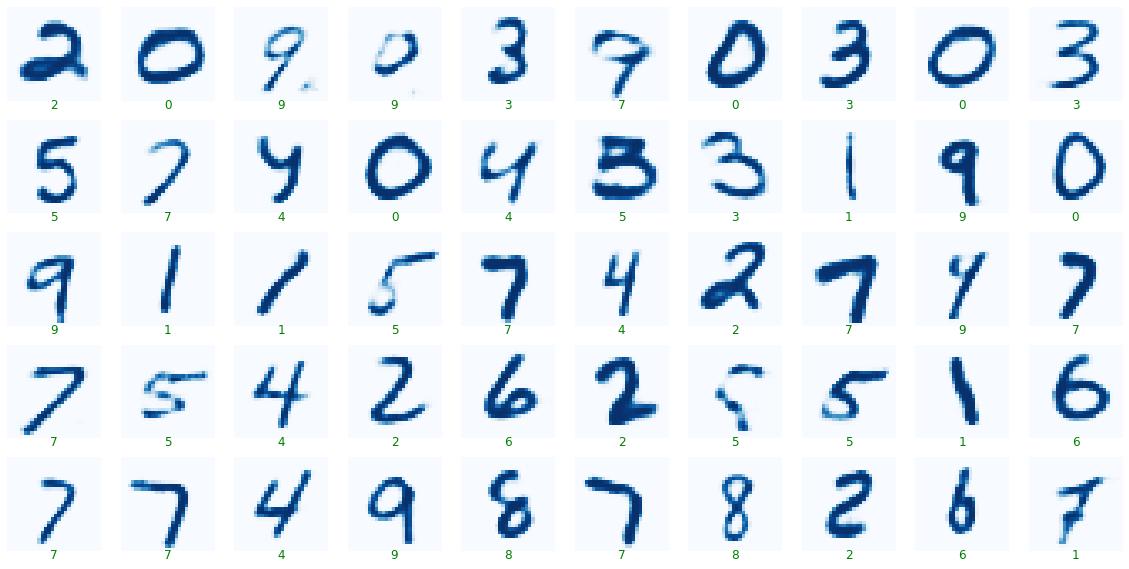

In [ ]:
# test random forest classifier on autoencoded values
rows = 5 
cols = 10 

f = plt.figure(figsize=(2*cols,2*rows))

for i in range(rows*cols): 
    f.add_subplot(rows,cols,i+1)
    plt.imshow(ae_test.values[i].reshape([28,28]),cmap="Blues") 
    plt.axis("off")
    plt.title(str(y_ae_test[i]), y=-0.15,color="green")